## Data Cleaning, Analysis, and Visualization

### This notebook explains the data cleaning process used in this project. Moreover, it also analyze the data and draws meaningful conclusions. 

##### Import libraries

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from random import randint
import seaborn as sns

##### Data cleaning process

In [40]:
'''Preprocessing Section'''
# Ref: https://www.kaggle.com/paramaggarwal/fashion-product-images-small

def remove_items(styles, col, item):
    """
    function to drop certain columns

    input: styles: dataframe
          col: column to drop items from
          item: items to drop
    return: dataframe
    """

    for i in item:
        styles = styles.drop(styles[styles[col] == i].index)
    return styles

def clean_df():
    """
    function to fetch and clean the data

    input : path to .csv
    return: dataframe
    """

    styles = pd.read_csv("./Dataset/styles.csv", on_bad_lines='skip')

    # drop unnecessary columns which are not needed to make recommendation
    styles = styles.drop(["productDisplayName", "year"], axis = 1) 
    styles = styles[(styles.masterCategory=='Apparel') | (styles.masterCategory=='Footwear')] 
    styles = styles.drop(styles[styles["subCategory"] == "Innerwear"].index)

    styles = styles.dropna() # drop NA
    styles = remove_items(styles, "subCategory", ["Apparel Set", "Dress", "Loungewear and Nightwear", "Saree", "Socks"])

    # group various footwear in one category
    styles["subCategory"] = styles["subCategory"].transform(lambda x: "Footwear" if(x in ["Shoes", "Flip Flops", "Sandal"]) else x) 
    styles["gender"] = styles["gender"].transform(lambda x: "Men" if(x in ["Men", "Boys"]) else x) 
    styles["gender"] = styles["gender"].transform(lambda x: "Women" if(x in ["Women", "Girls", "Unisex"]) else x) 
    # drop incomplete rows
    styles = styles.drop(labels=[6695, 16194, 32309, 36381, 40000], axis=0) 

    return styles

In [41]:
'''Clean up master dataframe through Preprocessing section'''
styles = clean_df()
styles

,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,Casual
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,Casual
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,Casual
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,Casual
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,Casual
...,...,...,...,...,...,...,...,...
44417,12544,Women,Apparel,Topwear,Tshirts,Peach,Fall,Casual
44418,42234,Women,Apparel,Topwear,Tops,Blue,Summer,Casual
44419,17036,Men,Footwear,Footwear,Casual Shoes,White,Summer,Casual
44420,6461,Men,Footwear,Footwear,Flip Flops,Red,Summer,Casual


In [42]:
len(styles.baseColour.unique()),styles.baseColour.unique()

(43,
 array(['Navy Blue', 'Blue', 'Black', 'Grey', 'Green', 'Purple', 'White',
        'Brown', 'Pink', 'Beige', 'Red', 'Khaki', 'Silver', 'Off White',
        'Yellow', 'Charcoal', 'Copper', 'Magenta', 'Orange', 'Lavender',
        'Sea Green', 'Cream', 'Peach', 'Gold', 'Tan', 'Olive', 'Burgundy',
        'Maroon', 'Grey Melange', 'Multi', 'Teal', 'Rust',
        'Turquoise Blue', 'Bronze', 'Mustard', 'Coffee Brown', 'Taupe',
        'Mauve', 'Mushroom Brown', 'Metallic', 'Nude', 'Lime Green',
        'Fluorescent Green'], dtype=object))

In the plots drawn below, we can easily see that we have a total of 43 colors in the dataset. Some of these colors are close and hard to distinguish. That is why we achieved a very low accuracy on a deep learning model to predict the color of the clothes. Because of that, we extracted the colors directly from the pictures instead of predicting it from a ML model.

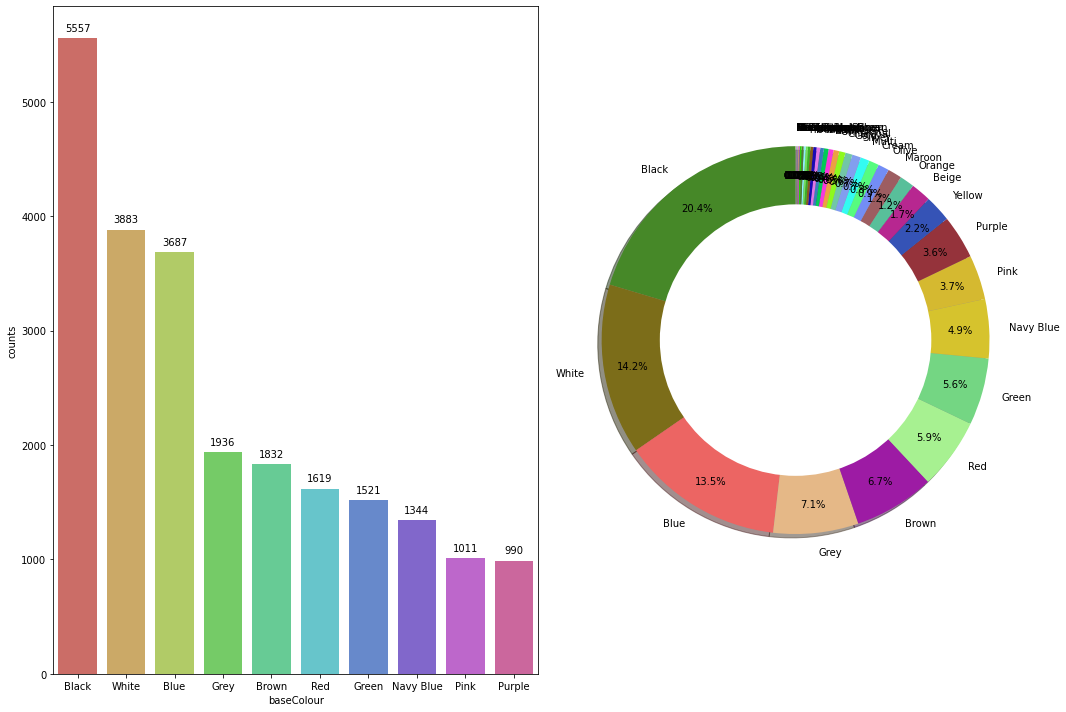

In [43]:
# plots to show the different colors present in the dataset

df = styles.copy()

df_colors = df.groupby(["baseColour"]).size().reset_index(name="counts").sort_values(by=["counts"], ascending=False)

# generate random hex color code
colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for n in range(df.baseColour.nunique())] 
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
ax = sns.barplot(x="baseColour", y="counts", data=df_colors.head(10), palette="hls", ax=axes[0])
for p in ax.patches:
    ax.annotate("%.2d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
axes[1].pie(list(df_colors.counts.values), labels=list(df_colors.baseColour.values), autopct="%1.1f%%", shadow=True, startangle=90, pctdistance=0.85, colors=colors)
center_cir = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_cir)
plt.tight_layout()
plt.show()

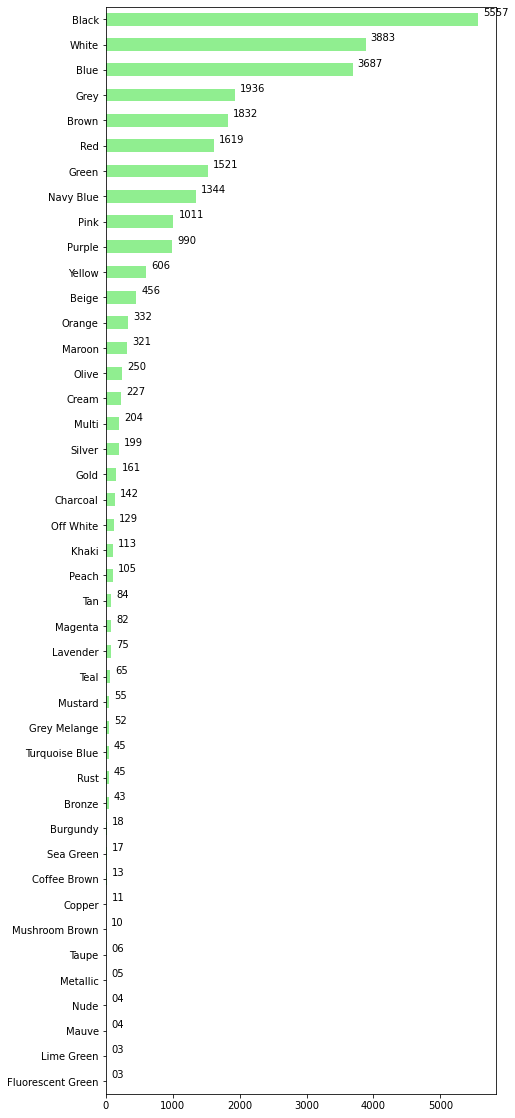

In [44]:
''' Plot all basecolours '''
plt.figure(figsize=(7,20))
ax = styles.baseColour.value_counts().sort_values().plot(kind='barh', color='lightgreen')
for p in ax.patches:
    ax.annotate("%.2d" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')


While using the color model, we observed that the model often incorrectly recognized black color. We believe that this behavior is observed because of the presence of a large amount of black colored clothes, thus causing data imbalance.

In [45]:
# change the original color column and grouping similar colors
styles.loc[(styles.baseColour=='Red')|
           (styles.baseColour=='Brown')|
           (styles.baseColour=='Coffee Brown')|
           (styles.baseColour=='Maroon')|
           (styles.baseColour=='Rust')|
           (styles.baseColour=='Burgundy')|
           (styles.baseColour=='Mushroom Brown'),"colorgroup"] = "Red"
styles.loc[(styles.baseColour=='Copper'),"colorgroup"] = "Dark Orange"
styles.loc[(styles.baseColour=='Orange')|
           (styles.baseColour=='Bronze')|
           (styles.baseColour=='Skin')|
           (styles.baseColour=='Nude'),"colorgroup"] = "Orange"
styles.loc[(styles.baseColour=='Gold')|
           (styles.baseColour=='Khaki')|
           (styles.baseColour=='Beige')|
           (styles.baseColour=='Mustard')|
           (styles.baseColour=='Tan')|
           (styles.baseColour=='Metallic'),"colorgroup"]= "Dark Yellow"
styles.loc[(styles.baseColour=='Yellow'),"colorgroup"] = "Yellow"
styles.loc[(styles.baseColour=='Lime Green'),"colorgroup"]= "Green"
styles.loc[(styles.baseColour=='Green')|
       (styles.baseColour=='Sea Green')|
       (styles.baseColour=='Fluorescent Green')|
       (styles.baseColour=='Olive'),"colorgroup"] = "Dark Green"
styles.loc[(styles.baseColour=='Teal')|
       (styles.baseColour=='Turquoise Blue'),"colorgroup"] = "Light Blue"
styles.loc[(styles.baseColour=='Blue'),"colorgroup"]= "Blue"
styles.loc[(styles.baseColour=='Navy Blue'),"colorgroup"] = "Dark Blue"
styles.loc[(styles.baseColour=='Purple')|
       (styles.baseColour=='Lavender'),"colorgroup"] = "Purple"
styles.loc[(styles.baseColour=='Pink')|
       (styles.baseColour=='Magenta')|
       (styles.baseColour=='Peach')|
       (styles.baseColour=='Rose')|
       (styles.baseColour=='Mauve'),"colorgroup"] = "Pink"
styles.loc[(styles.baseColour=='Black')|
       (styles.baseColour=='Charcoal'),"colorgroup"] = "Black"
styles.loc[(styles.baseColour=='White')|
       (styles.baseColour=='Off White')|
       (styles.baseColour=='Cream'),"colorgroup"] = "White"
styles.loc[(styles.baseColour=='Grey')|
       (styles.baseColour=='Silver')|
       (styles.baseColour=='Taupe')|
       (styles.baseColour=='Grey Melange'),"colorgroup"] = "Grey"
styles.loc[(styles.baseColour=='Multi'),"colorgroup"] = "Multi"

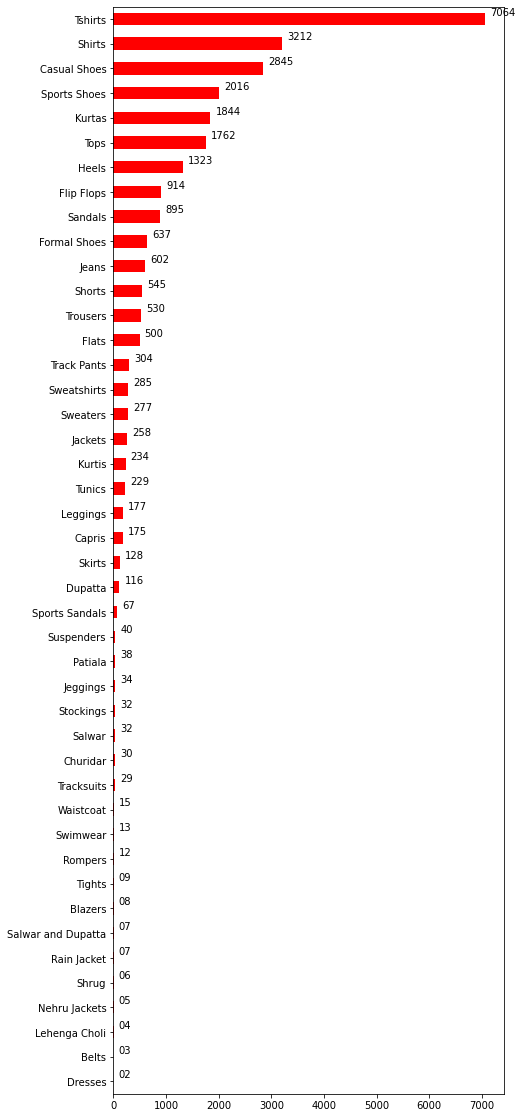

In [46]:
# Plot distribution of articletype present in dataset
plt.figure(figsize=(7,20))
bx = styles.articleType.value_counts().sort_values().plot(kind='barh', color='red')
for p in bx.patches:
    bx.annotate("%.2d" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')

As we can easily observe that there are a lot of T-shirts in the dataset as compared to other clothes like Blazers, Tights, Rompers etc., which is consistent with the fact that our model often misidentifies to T-shirts.

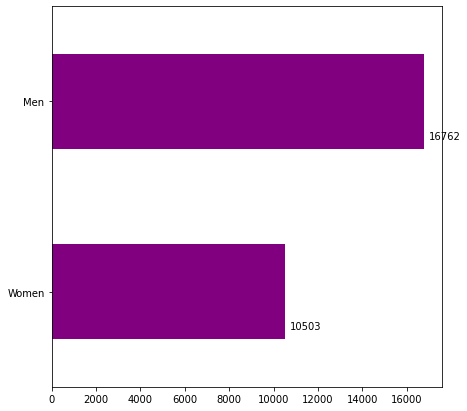

In [47]:
# plot to show IDs per gender class
plt.figure(figsize=(7,7))
cx = styles.gender.value_counts().sort_values().plot(kind='barh', color='purple')
for p in cx.patches:
    cx.annotate("%.2d" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')

Dataset biased towards Men's clothes 